In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_path = "/Users/kahaan/Desktop/multi-armed-bandits/netflix-recommendations/data/"

In [2]:
def load_subset(data_path, check=False):
    train_path = data_path + "training_ratings.txt"
    test_path = data_path + "testing_ratings.txt"
    title_path = data_path + "movie_titles.txt"
    genre_path = data_path + "movie_genres.csv"

    # Read in movie titles line by line
    titles = []
    with open(title_path, 'r', encoding='latin1') as file:
        for line in file:
            # Maximum of 2 splits per line, avoiding commas in movie name
            parts = line.strip().split(',', 2)
            # Verify succesful split
            if len(parts) == 3:
                titles.append(parts)
            else:
                print(f"Skipped malformed line: {line}")

    # Create DataFrame for raw data
    df_titles = pd.DataFrame(titles, columns=['MovieID', 'Year', 'Title'])
    df_train = pd.read_csv(train_path, header=None, names=["MovieID", "UserID", "Rating"])
    df_test = pd.read_csv(test_path, header=None, names=["MovieID", "UserID", "Rating"])

    # Combine similar formatted data, and set correct data types for later merges
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    df_genres = pd.read_csv(genre_path, names=["MovieID", "Genres"]).drop(index=0)
    df_combined['MovieID'] = df_combined['MovieID'].astype(int)
    df_genres['MovieID'] = df_genres['MovieID'].astype(int)
    df_titles['MovieID'] = df_titles['MovieID'].astype(int)

    # Merge datasets
    df_merge1 = pd.merge(df_combined, df_genres, on='MovieID', how='inner')
    df_subset = pd.merge(df_merge1, df_titles, on='MovieID', how='inner')

    if check:
        # Verify minimum entries per user
        entries_per_user = df_subset.groupby('UserID').size()
        smallest_entries_count = entries_per_user.min()
        print(f"The smallest amount of entries for any UserID is: {smallest_entries_count}")

    return df_subset

In [3]:
subset = load_subset(data_path)

# Split genres into lists and expand each genre into seprate row
subset['Genres'] = subset['Genres'].str.split('|') 
df_exploded = subset.explode('Genres') 
unique_genres = df_exploded.Genres.unique()
df_exploded

,MovieID,UserID,Rating,Genres,Year,Title
0,8,1744889,1.0,Documentary,2004,What the #$*! Do We Know!?
0,8,1744889,1.0,Comedy,2004,What the #$*! Do We Know!?
0,8,1744889,1.0,Drama,2004,What the #$*! Do We Know!?
0,8,1744889,1.0,Fantasy,2004,What the #$*! Do We Know!?
0,8,1744889,1.0,Mystery,2004,What the #$*! Do We Know!?
...,...,...,...,...,...,...
2891056,17742,2646347,5.0,Romance,1995,Catherine the Great
2891057,17742,273576,2.0,Biography,1995,Catherine the Great
2891057,17742,273576,2.0,Drama,1995,Catherine the Great
2891057,17742,273576,2.0,History,1995,Catherine the Great


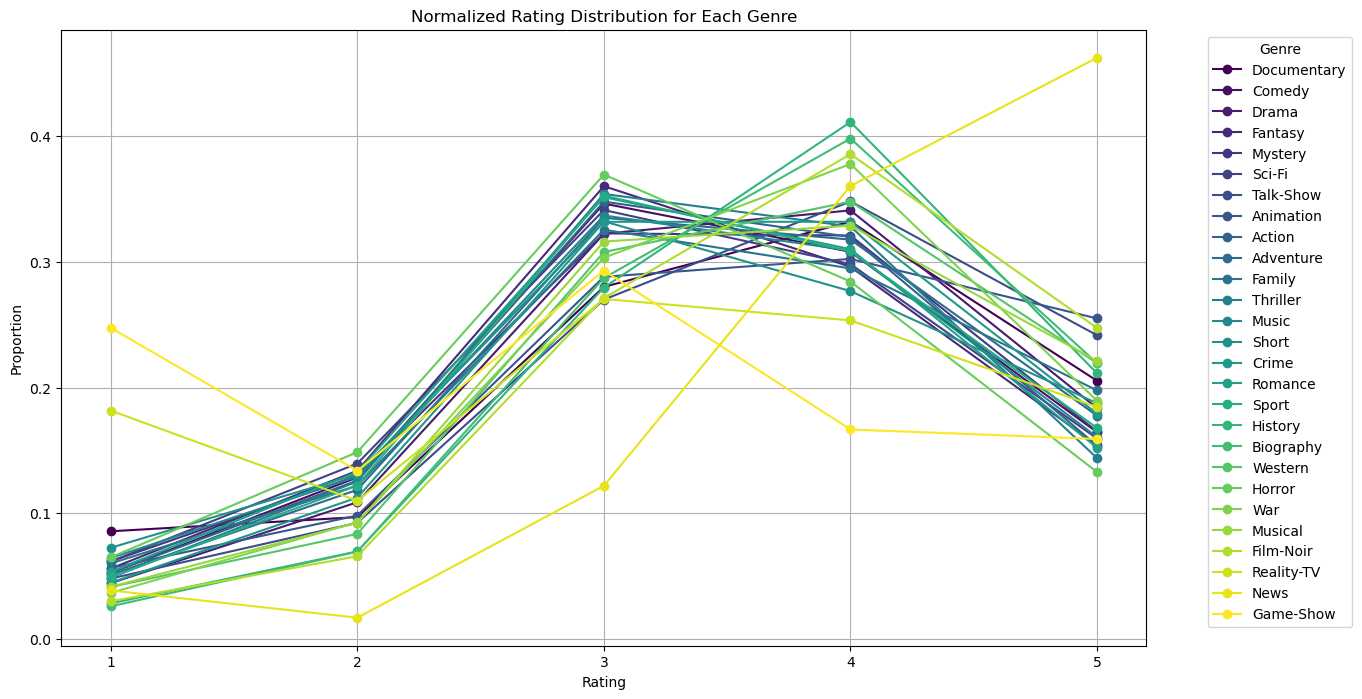

In [4]:
plt.figure(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))
for genre, color in zip(unique_genres, colors):
    subset = df_exploded[df_exploded['Genres'] == genre]['Rating']
    rating_counts = {rating: 0 for rating in range(1, 6)}

    for rating in subset:
        if rating in rating_counts:
            rating_counts[rating] += 1
    
    # Normalizing the counts
    total_counts = sum(rating_counts.values())
    normalized_counts = {rating: (count / total_counts) for rating, count in rating_counts.items()}
    
    plt.plot(list(normalized_counts.keys()), list(normalized_counts.values()), '-o', label=genre, color=color)

plt.title('Normalized Rating Distribution for Each Genre')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(range(1, 6))
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [5]:
# Calculate various useful average metrics
avg_rating_per_genre = df_exploded.groupby('Genres')['Rating'].mean()
avg_rating_per_movie = df_exploded.groupby('MovieID')['Rating'].mean()
avg_rating_per_user = df_exploded.groupby('UserID')['Rating'].mean()
overall_avg_rating = df_exploded['Rating'].mean()

# Incorporated metrics into DataFrame 
df_exploded['RatingVsGenreAvg'] = df_exploded.apply(lambda row: row['Rating'] - avg_rating_per_genre[row['Genres']], axis=1)
df_exploded['RatingVsMovieAvg'] = df_exploded.apply(lambda row: row['Rating'] - avg_rating_per_movie[row['MovieID']], axis=1)
df_exploded['RatingVsUserAvg'] = df_exploded.apply(lambda row: row['Rating'] - avg_rating_per_user[row['UserID']], axis=1)
df_exploded['RatingVsOverallAvg'] = df_exploded['Rating'] - overall_avg_rating

print(avg_rating_per_genre)
df_exploded

Genres
Action         3.395939
Adventure      3.451878
Animation      3.600768
Biography      3.715011
Comedy         3.402529
Crime          3.487920
Documentary    3.474222
Drama          3.510211
Family         3.447758
Fantasy        3.357993
Film-Noir      3.754297
Game-Show      2.856061
History        3.707150
Horror         3.271222
Music          3.371979
Musical        3.595327
Mystery        3.397449
News           4.190165
Reality-TV     3.149042
Romance        3.374194
Sci-Fi         3.354015
Short          3.375444
Sport          3.423497
Talk-Show      3.642333
Thriller       3.392830
War            3.590142
Western        3.620081
Name: Rating, dtype: float64


,MovieID,UserID,Rating,Genres,Year,Title,RatingVsGenreAvg,RatingVsMovieAvg,RatingVsUserAvg,RatingVsOverallAvg
0,8,1744889,1.0,Documentary,2004,What the #$*! Do We Know!?,-2.474222,-2.055688,-1.305136,-2.440962
0,8,1744889,1.0,Comedy,2004,What the #$*! Do We Know!?,-2.402529,-2.055688,-1.305136,-2.440962
0,8,1744889,1.0,Drama,2004,What the #$*! Do We Know!?,-2.510211,-2.055688,-1.305136,-2.440962
0,8,1744889,1.0,Fantasy,2004,What the #$*! Do We Know!?,-2.357993,-2.055688,-1.305136,-2.440962
0,8,1744889,1.0,Mystery,2004,What the #$*! Do We Know!?,-2.397449,-2.055688,-1.305136,-2.440962
...,...,...,...,...,...,...,...,...,...,...
2891056,17742,2646347,5.0,Romance,1995,Catherine the Great,1.625806,2.220472,1.543233,1.559038
2891057,17742,273576,2.0,Biography,1995,Catherine the Great,-1.715011,-0.779528,-1.625000,-1.440962
2891057,17742,273576,2.0,Drama,1995,Catherine the Great,-1.510211,-0.779528,-1.625000,-1.440962
2891057,17742,273576,2.0,History,1995,Catherine the Great,-1.707150,-0.779528,-1.625000,-1.440962


In [21]:
# Average viewers: strong correlation between their rating distribution and average rating distribution 

overall_rating_counts = df_exploded['Rating'].value_counts(normalize=True)
user_rating_distribution = df_exploded.groupby('UserID')['Rating'].value_counts(normalize=True).unstack(fill_value=0)
correlations = user_rating_distribution.corrwith(overall_rating_counts, axis=1)
average_viewer_threshold = 0.8
average_viewers = correlations[correlations >= average_viewer_threshold]
num_average_viewers = average_viewers.count()
num_average_viewers

16655

In [6]:
# Genre enjoyers: average rating for a genre is significantly higher than their overall averate rating

threshold = 0.5
user_overall_avg_rating = df_exploded.groupby('UserID')['Rating'].mean()
user_genre_avg_rating = df_exploded.groupby(['UserID', 'Genres'])['Rating'].mean().unstack(fill_value=0)
genre_preference = user_genre_avg_rating.subtract(user_overall_avg_rating, axis='index')
genre_enjoyers = genre_preference > threshold
num_genre_enjoyers = genre_enjoyers.any(axis='columns').sum()
num_genre_enjoyers

26385

In [7]:
# Niche genre loyalists: preference for one or more niche genres

# Determine niche genres based on threshold
movies_per_genre = df_exploded.groupby('Genres')['MovieID'].nunique()
ratings_per_genre = df_exploded.groupby('Genres')['Rating'].count()
threshold_movies = movies_per_genre.quantile(0.25)
threshold_ratings = ratings_per_genre.quantile(0.25)
niche_genres = movies_per_genre[movies_per_genre <= threshold_movies].index.tolist()

# Compare overall average rating to niche genre rating
user_genre_avg_rating = df_exploded.groupby(['UserID', 'Genres'])['Rating'].mean().unstack(fill_value=0)
user_overall_avg_rating = df_exploded.groupby('UserID')['Rating'].mean()
niche_user_genre_ratings = user_genre_avg_rating[niche_genres]
niche_preference = niche_user_genre_ratings.subtract(user_overall_avg_rating, axis=0)

# Identify users with a strong preference for niche genres
threshold = 0.5
niche_loyalists = niche_preference > threshold
num_niche_loyalists = (niche_loyalists.any(axis=1)).sum()
num_niche_loyalists

15057

In [8]:
# Quality seekers: biased towards high-quality moves, rating them disproportionately higher

# Filter movies that are considered high quality, and their ratings
average_rating_per_movie = df_exploded.groupby('MovieID')['Rating'].mean()
quality_threshold = average_rating_per_movie.quantile(0.75)
high_quality_movies = average_rating_per_movie[average_rating_per_movie >= quality_threshold].index
high_quality_movie_ratings = df_exploded[df_exploded['MovieID'].isin(high_quality_movies)]

# Calculate average rating given by each user to these high-quality movies
user_avg_rating_for_high_quality = high_quality_movie_ratings.groupby('UserID')['Rating'].mean()

# Identify users with average rating for high-quality movies above overall average
overall_avg_rating = df_exploded['Rating'].mean()
quality_seekers = user_avg_rating_for_high_quality[user_avg_rating_for_high_quality > overall_avg_rating]
num_quality_seekers = quality_seekers.count()
num_quality_seekers

22377

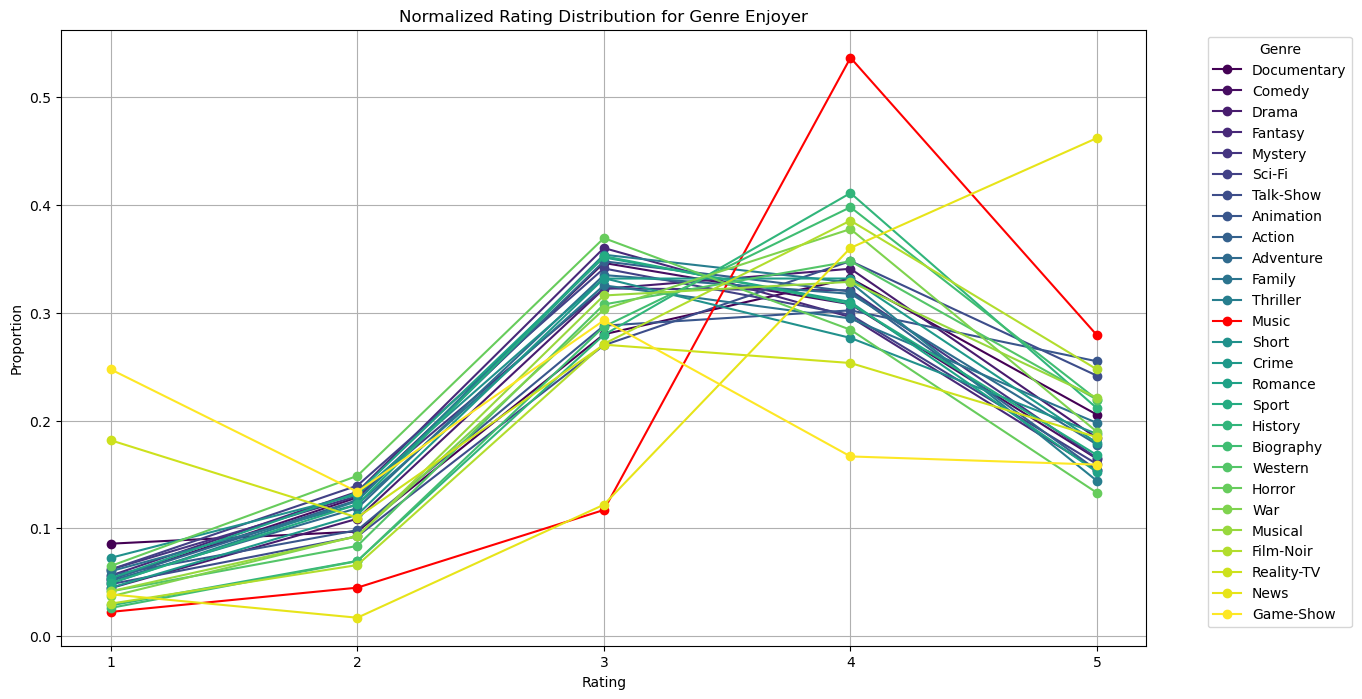

In [22]:
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))

for genre, color in zip(unique_genres, colors):
    subset = df_exploded[df_exploded['Genres'] == genre]['Rating']
    rating_counts = {rating: 0 for rating in range(1, 6)}
    
    for rating in subset:
        if rating in rating_counts:
            rating_counts[rating] += 1
    
    # Apply bias if genre is 'Music', increasing counts of 4s and 5s
    if genre == 'Music':
        bias_factor = 5 
        rating_counts[4] = int(rating_counts[4] * bias_factor)
        rating_counts[5] = int(rating_counts[5] * bias_factor)
    
    # Normalize counts
    total_counts = sum(rating_counts.values())
    normalized_counts = {rating: (count / total_counts) for rating, count in rating_counts.items()}
    
    if genre == 'Music':
        plt.plot(list(normalized_counts.keys()), list(normalized_counts.values()), '-o', label=genre, color="red")
    else:
        plt.plot(list(normalized_counts.keys()), list(normalized_counts.values()), '-o', label=genre, color=color)

plt.title('Normalized Rating Distribution for Genre Enjoyer')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(range(1, 6))
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

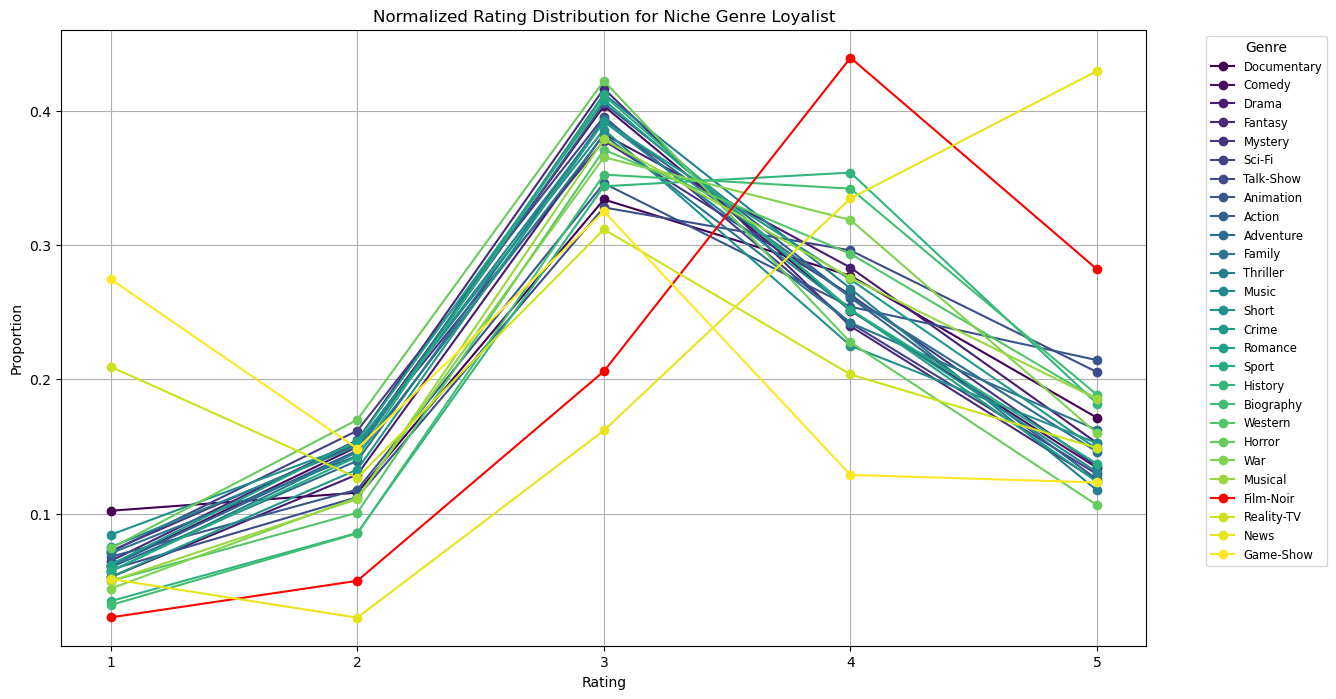

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))

for genre, color in zip(unique_genres, colors):
    subset = df_exploded[df_exploded['Genres'] == genre]['Rating']
    rating_counts = {rating: 0 for rating in range(1, 6)}

    for rating in subset:
        if rating in rating_counts:
            rating_counts[rating] += 1
    
    # Apply bias if genre is 'Film-Noir', else apply nerf
    if genre == 'Film-Noir':
        bias_factor = 1.5  
        rating_counts[4] = int(rating_counts[4] * bias_factor)
        rating_counts[5] = int(rating_counts[5] * bias_factor)
    else:
        nerf_factor = 0.7
        rating_counts[4] = int(rating_counts[4] * nerf_factor)
        rating_counts[5] = int(rating_counts[5] * nerf_factor)
    
    # Normalize counts
    total_counts = sum(rating_counts.values())
    normalized_counts = {rating: (count / total_counts) for rating, count in rating_counts.items()}
    if genre == 'Film-Noir':
        plt.plot(list(normalized_counts.keys()), list(normalized_counts.values()), '-o', label=genre, color="red")
    else:
        plt.plot(list(normalized_counts.keys()), list(normalized_counts.values()), '-o', label=genre, color=color)

plt.title('Normalized Rating Distribution for Niche Genre Loyalist')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(range(1, 6))
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()